In [1]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
# 2. LOAD DATA
df = pd.read_csv('/content/RegresiUTSTelkom.csv') # lokasi file di Google Colab

print("Data Overview:")
print(df.head())
print("\nInfo:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())



Data Overview:
   2001  49.94357  21.47114   73.0775   8.74861  -17.40628  -13.09905  \
0  2001  48.73215  18.42930  70.32679  12.94636  -10.32437  -24.83777   
1  2001  50.95714  31.85602  55.81851  13.41693   -6.57898  -18.54940   
2  2001  48.24750  -1.89837  36.29772   2.58776    0.97170  -26.21683   
3  2001  50.97020  42.20998  67.09964   8.46791  -15.85279  -16.81409   
4  2001  50.54767   0.31568  92.35066  22.38696  -25.51870  -19.04928   

   -25.01202  -12.23257   7.83089  ...   13.0162  -54.40548  58.99367  \
0    8.76630   -0.92019  18.76548  ...   5.66812  -19.68073  33.04964   
1   -3.27872   -2.35035  16.07017  ...   3.03800   26.05866 -50.92779   
2    5.05097  -10.34124   3.55005  ...  34.57337 -171.70734 -16.96705   
3  -12.48207   -9.37636  12.63699  ...   9.92661  -55.95724  64.92712   
4   20.67345   -5.19943   3.63566  ...   6.59753  -50.69577  26.02574   

   15.37344   1.11144  -23.08793   68.40795  -1.82223  -27.46348   2.26327  
0  42.87836  -9.90378  -32.227

In [4]:
# 3. DATA CLEANING
# Misalnya drop baris/kolom kosong (jika ada)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [5]:
# 4. FEATURE SELECTION

# 4.1 Remove Constant & Quasi-Constant
selector = VarianceThreshold(threshold=0.01)
selector.fit(df.select_dtypes(include=[np.number]))
constant_columns = [column for column in df.select_dtypes(include=[np.number]).columns if column not in df.columns[selector.get_support()]]
print(f"Constant/Quasi-Constant Columns: {constant_columns}")

Constant/Quasi-Constant Columns: []


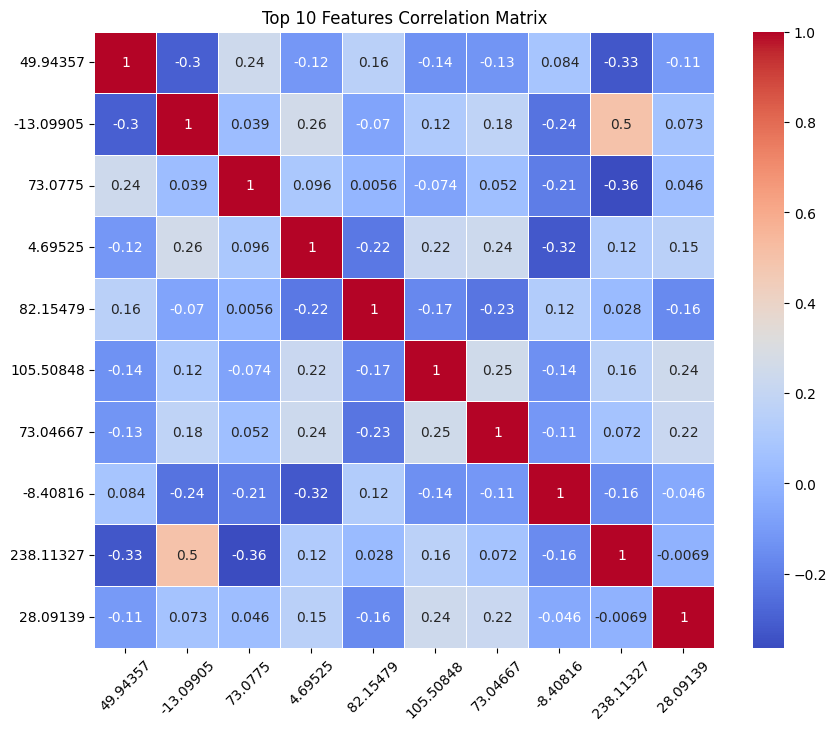

In [6]:
# 4.3 Correlation
corr_matrix = df.corr()
target_col = '2001'  # ganti dengan nama kolom target asli
cor_target = abs(corr_matrix[target_col]).sort_values(ascending=False)

top_features = cor_target[1:11].index  # ambil 10 fitur (selain target itu sendiri)
plt.figure(figsize=(10,8))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Top 10 Features Correlation Matrix')
plt.xticks(rotation=45)
plt.show()



In [7]:
# 4.4 Mutual Information (Feature Importance)
X = df.drop('2001', axis=1)  # Ganti 'target' dengan nama target sebenarnya
y = df['2001']

mi = mutual_info_regression(X.select_dtypes(include=[np.number]), y)
mi_series = pd.Series(mi, index=X.select_dtypes(include=[np.number]).columns)
mi_series = mi_series.sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_series)


Mutual Information Scores:
49.94357     0.056281
-13.09905    0.041601
73.0775      0.039179
238.11327    0.030864
82.15479     0.029505
               ...   
7.19877      0.001193
15.93809     0.000125
-25.38187    0.000000
-37.13767    0.000000
-27.46348    0.000000
Length: 90, dtype: float64


In [8]:
# 5. FEATURE ENGINEERING

# Identify categorical and numerical
categorical = X.select_dtypes(include=['object']).columns.tolist()
numerical = X.select_dtypes(include=[np.number]).columns.tolist()

print("\nCategorical Features:", categorical)
print("Numerical Features:", numerical)

# Preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical),
    ('cat', categorical_pipeline, categorical)
])


Categorical Features: []
Numerical Features: ['49.94357', '21.47114', '73.0775', '8.74861', '-17.40628', '-13.09905', '-25.01202', '-12.23257', '7.83089', '-2.46783', '3.32136', '-2.31521', '10.20556', '611.10913', '951.0896', '698.11428', '408.98485', '383.70912', '326.51512', '238.11327', '251.42414', '187.17351', '100.42652', '179.19498', '-8.41558', '-317.87038', '95.86266', '48.10259', '-95.66303', '-18.06215', '1.96984', '34.42438', '11.7267', '1.3679', '7.79444', '-0.36994', '-133.67852', '-83.26165', '-37.29765', '73.04667', '-37.36684', '-3.13853', '-24.21531', '-13.23066', '15.93809', '-18.60478', '82.15479', '240.5798', '-10.29407', '31.58431', '-25.38187', '-3.90772', '13.29258', '41.5506', '-7.26272', '-21.00863', '105.50848', '64.29856', '26.08481', '-44.5911', '-8.30657', '7.93706', '-10.7366', '-95.44766', '-82.03307', '-35.59194', '4.69525', '70.95626', '28.09139', '6.02015', '-37.13767', '-41.1245', '-8.40816', '7.19877', '-8.60176', '-5.90857', '-12.32437', '14.6873

In [9]:
# 6. MODELING
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression (degree=2)': Pipeline([
        ('poly_features', PolynomialFeatures(degree=2)),
        ('lin_reg', LinearRegression())
    ]),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'Bagging': BaggingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

In [10]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Linear Regression:
  MSE  : 90.0743
  RMSE : 9.4908
  R2   : 0.2218


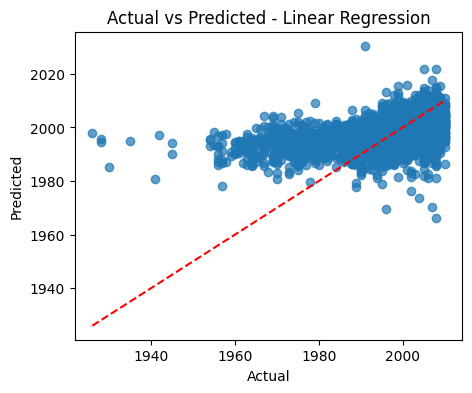


Polynomial Regression (degree=2):
  MSE  : 211.0979
  RMSE : 14.5292
  R2   : -0.8239


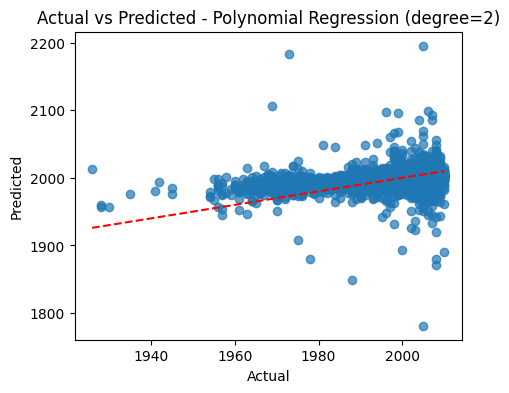


Decision Tree:
  MSE  : 183.0599
  RMSE : 13.5300
  R2   : -0.5816


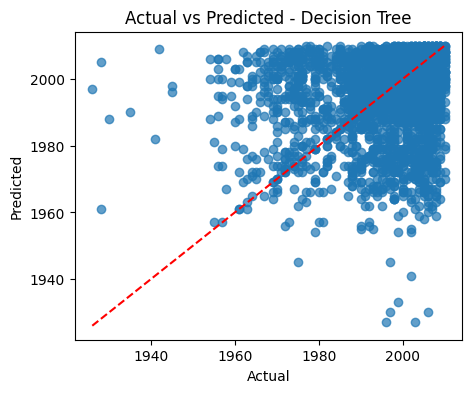


KNN:
  MSE  : 85.2580
  RMSE : 9.2335
  R2   : 0.2634


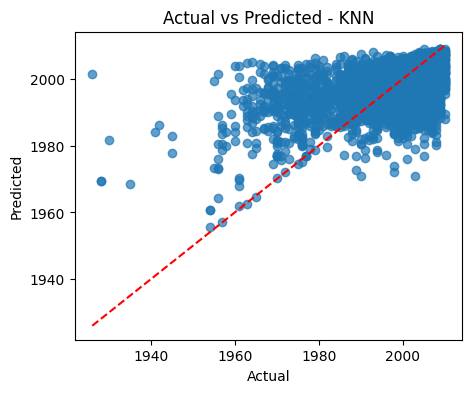


Bagging:
  MSE  : 93.9526
  RMSE : 9.6929
  R2   : 0.1883


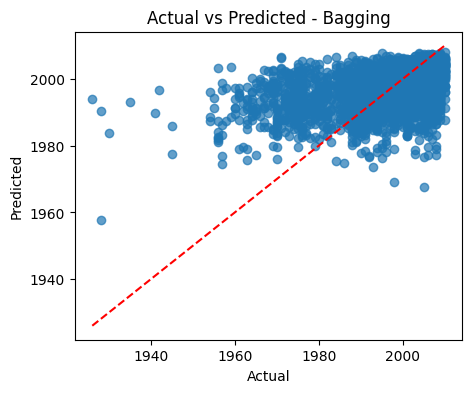


AdaBoost:
  MSE  : 183.8019
  RMSE : 13.5574
  R2   : -0.5880


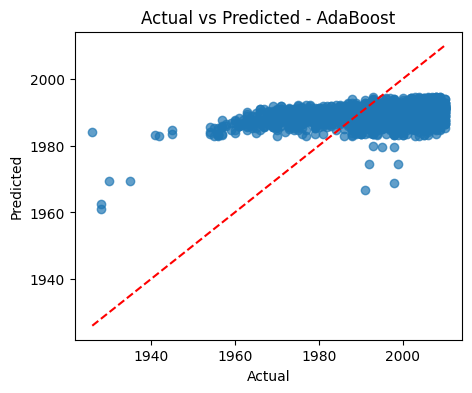


GradientBoosting:
  MSE  : 84.8716
  RMSE : 9.2126
  R2   : 0.2667


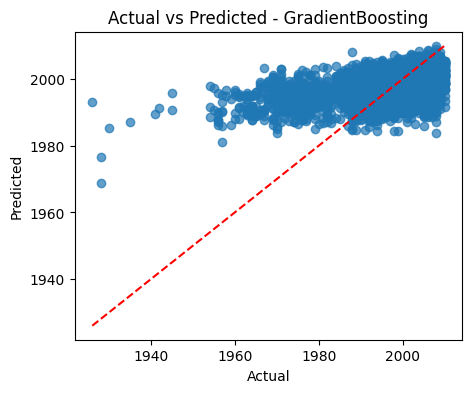


SVR:
  MSE  : 92.2614
  RMSE : 9.6053
  R2   : 0.2029


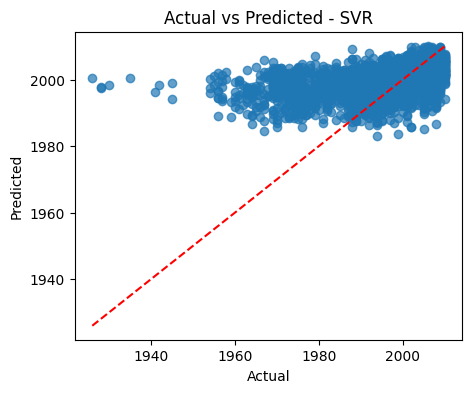

In [11]:
# 7. TRAINING & EVALUATION
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
    print(f"\n{name}:")
    print(f"  MSE  : {mse:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  R2   : {r2:.4f}")

    # Visualisasi Prediksi vs Aktual
    plt.figure(figsize=(5,4))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted - {name}')
    plt.show()


In [12]:
# 8. KESIMPULAN (Analisa Model)
result_df = pd.DataFrame(results).T
print("\n=== Summary Results ===")
print(result_df)

best_model = result_df['RMSE'].idxmin()
print(f"\nModel Terbaik berdasarkan RMSE adalah: {best_model}")


=== Summary Results ===
                                         MSE       RMSE        R2
Linear Regression                  90.074340   9.490750  0.221771
Polynomial Regression (degree=2)  211.097921  14.529209 -0.823856
Decision Tree                     183.059923  13.529964 -0.581611
KNN                                85.258018   9.233527  0.263383
Bagging                            93.952588   9.692914  0.188263
AdaBoost                          183.801868  13.557355 -0.588022
GradientBoosting                   84.871580   9.212577  0.266722
SVR                                92.261366   9.605278  0.202875

Model Terbaik berdasarkan RMSE adalah: GradientBoosting
